In [47]:
import tushare as ts
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

In [6]:
ts.set_token('73c1bd181e417b067a37d836c714f2b683feeaa47a0da1f4f27c9dca')
pro = ts.pro_api()

In [18]:
df1 = pro.daily(ts_code='601169.SH', start_date='20200101', end_date='20220606')

In [19]:
df2 = pro.daily(ts_code='601328.SH', start_date='20200101', end_date='20220606')

In [21]:
data1 = df1[['trade_date','close']]
data2 = df2['close']
data = pd.concat([data1, data2], axis=1)
data.head()

,trade_date,close,close
0,20220602,4.43,4.92
1,20220601,4.43,4.92
2,20220531,4.42,4.91
3,20220530,4.42,4.91
4,20220527,4.45,4.97


In [25]:
data['trade_date'] = pd.to_datetime(data['trade_date'])
data.head()

,trade_date,close,close
0,2022-06-02,4.43,4.92
1,2022-06-01,4.43,4.92
2,2022-05-31,4.42,4.91
3,2022-05-30,4.42,4.91
4,2022-05-27,4.45,4.97


In [31]:
data = data.rename(columns={"trade_date":"time"})

In [33]:
data.set_index('time', inplace=True)

In [35]:
data.columns = ['601169', '601328']

In [36]:
data.head()

,601169,601328
time,,
2022-06-02,4.43,4.92
2022-06-01,4.43,4.92
2022-05-31,4.42,4.91
2022-05-30,4.42,4.91
2022-05-27,4.45,4.97


In [37]:
data[['601169', '601328']].isnull().any()

601169    False
601328    False
dtype: bool

## 执行策略

In [39]:
# 用x数据对y数据进行拟合
[slope, intercept] = np.polyfit(data.iloc[:,0], data.iloc[:,1], 1).round(2)
slope, intercept

(0.74, 1.3)

In [42]:
# 计算残差
data['spread'] = data.iloc[:,1] - (data.iloc[:,0]*slope + intercept)

<AxesSubplot:title={'center':'Price Spread'}, xlabel='time'>

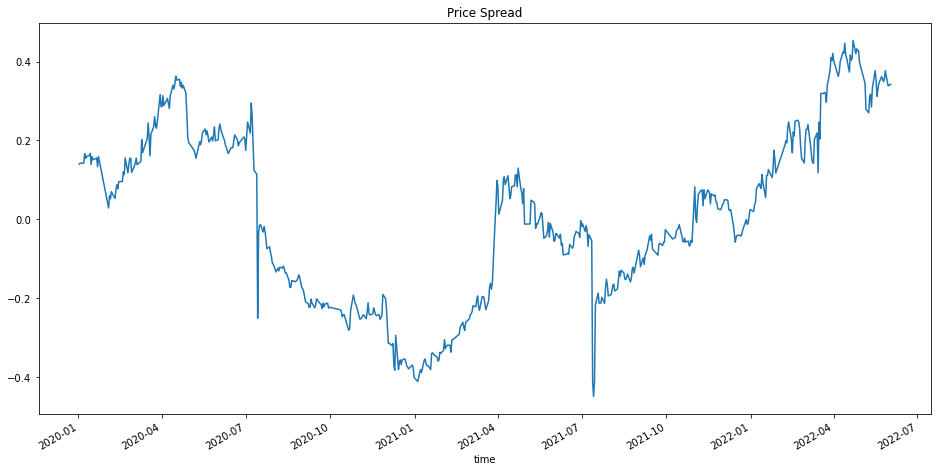

In [43]:
data['spread'].plot(figsize=(16,8), title="Price Spread")

In [49]:
# 标准化价差：Z Score
data['zscore'] = (data['spread']-data['spread'].mean())/data['spread'].std()

In [50]:
data.head()

,601169,601328,spread,zscore
time,,,,
2022-06-02,4.43,4.92,0.3418,1.570933
2022-06-01,4.43,4.92,0.3418,1.570933
2022-05-31,4.42,4.91,0.3392,1.558883
2022-05-30,4.42,4.91,0.3392,1.558883
2022-05-27,4.45,4.97,0.3770,1.734068


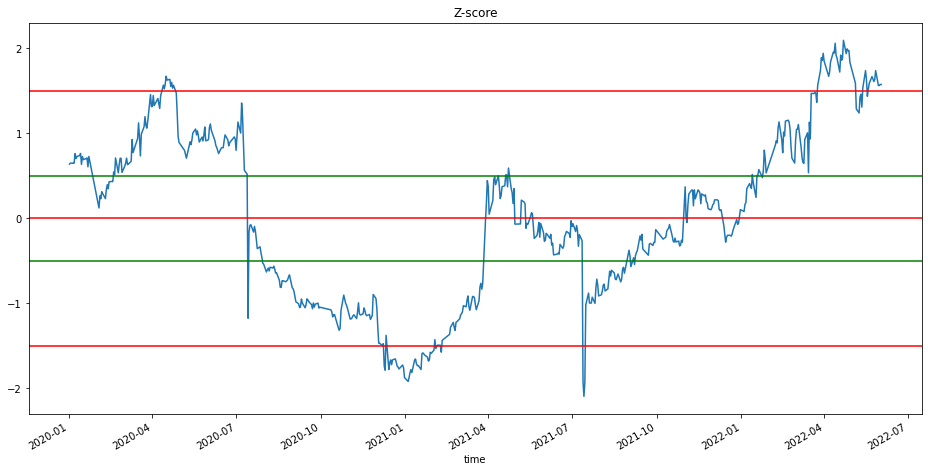

In [51]:
# Draw the plot
data['zscore'].plot(figsize=(16,8), title='Z-score')
plt.axhline(1.5, color='r')
plt.axhline(0.5, color='g')
plt.axhline(0, color='r')
plt.axhline(-0.5, color='g')
plt.axhline(-1.5, color='r')

In [52]:
# 策略逻辑
data['position_1'] = np.where(data['zscore']>1.5, 1, np.nan)
data['position_1'] = np.where(data['zscore']<-1.5,-1, data['position_1'])
data['position_1'] = np.where(abs(data['zscore'])<0.5, 0, data['position_1'])

<AxesSubplot:title={'center':'Trading Signal Uptrade'}, xlabel='time'>

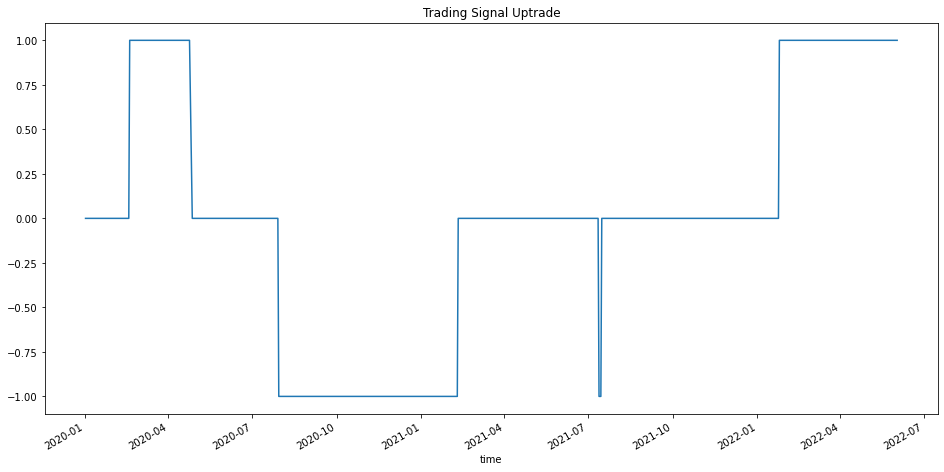

In [54]:
data['position_1'] = data['position_1'].fillna(method = 'ffill')
data['position_1'].plot(ylim=[-1.1, 1.1], figsize=(16,8), title='Trading Signal Uptrade')

<AxesSubplot:xlabel='time'>

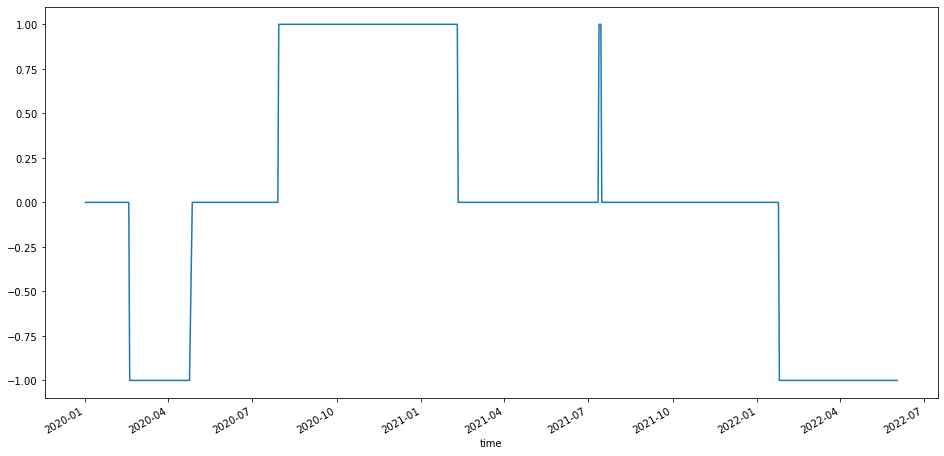

In [56]:
data['position_2'] = -data['position_1']
data['position_2'].plot(ylim=[-1.1, 1.1], figsize=(16,8))

In [57]:
data['returns_1'] = np.log(data['601169'] / data['601169'].shift(1))
data['returns_2'] = np.log(data['601328'] / data['601328'].shift(1))
data.head()

,601169,601328,spread,zscore,position_1,position_2,returns_1,returns_2
time,,,,,,,,
2022-06-02,4.43,4.92,0.3418,1.570933,1.0,-1.0,NaN,NaN
2022-06-01,4.43,4.92,0.3418,1.570933,1.0,-1.0,0.000000,0.000000
2022-05-31,4.42,4.91,0.3392,1.558883,1.0,-1.0,-0.002260,-0.002035
2022-05-30,4.42,4.91,0.3392,1.558883,1.0,-1.0,0.000000,0.000000
2022-05-27,4.45,4.97,0.3770,1.734068,1.0,-1.0,0.006764,0.012146


In [63]:
# Calculate the result of our strategy
data['strategy'] = 0.1*(data['position_1'].shift(1)*data['returns_1']) + 0.9*(data['position_2'].shift(1)*data['returns_2'])

<AxesSubplot:title={'center':'Strategy Result'}, xlabel='time'>

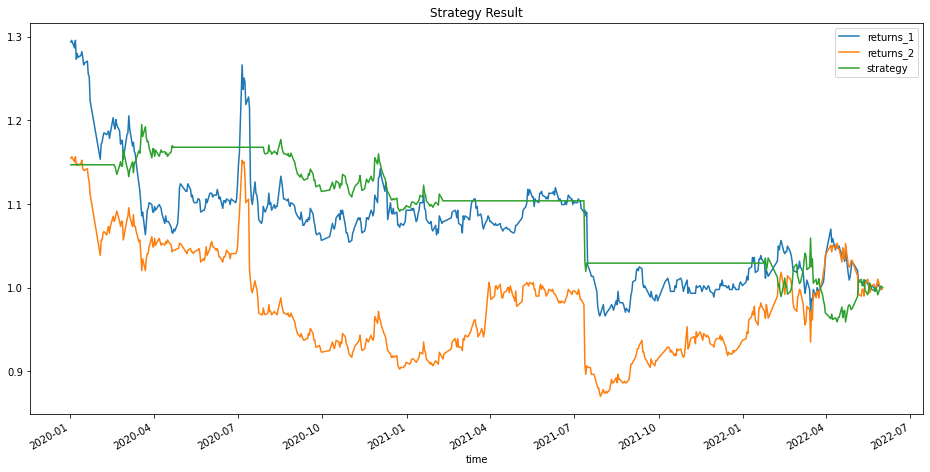

In [64]:
data[['returns_1','returns_2','strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(16,8), title = 'Strategy Result')